In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
import pickle
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from scipy.sparse import csr_matrix, hstack
from sklearn.cross_validation import KFold, train_test_split
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# This may raise an exception in earlier versions of Jupyter
%config InlineBackend.figure_format = 'retina'

C:\Users\87613\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\87613\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
import pandas as pd
train = pd.read_csv('./data/./train_no_id.csv')
train_y = pd.read_csv('./data/label.csv',names = ['label'])
pd_3 = pd.read_csv('./data/test.csv') 


features = ['register_day','register_type','device type','user_activity_day','video_create_day','p_0','p_1','p_2','p_3','p_4','a_0','a_1','a_2','a_3','a_4','a_5']

train_x = train[features]
train_y = train_y['label']

print ("Xtrain:", train_x.shape)
print ("ytrain:", train_y.shape)

Xtrain: (40518, 16)
ytrain: (40518,)


In [3]:
def xg_eval_mae(yhat, dtrain):
    y = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(y), np.exp(yhat))

In [4]:
dtrain = xgb.DMatrix(train_x, train_y)

In [5]:
xgb_params = {
    'seed': 0,
    'eta': 0.1,
    'colsample_bytree': 0.5,
    'silent': 1,
    'subsample': 0.5,
    'objective': 'reg:linear',
    'max_depth': 5,
    'min_child_weight': 3
}

In [6]:
%%time


        

bst_cv1 = xgb.cv(xgb_params, dtrain, num_boost_round=50, nfold=3, seed=0, 
                feval=xg_eval_mae, maximize=False, early_stopping_rounds=10)

print ('CV score:', bst_cv1.iloc[-1,:]['test-mae-mean'])

CV score: 0.44793066666666664
Wall time: 2.33 s


<Figure size 432x288 with 0 Axes>

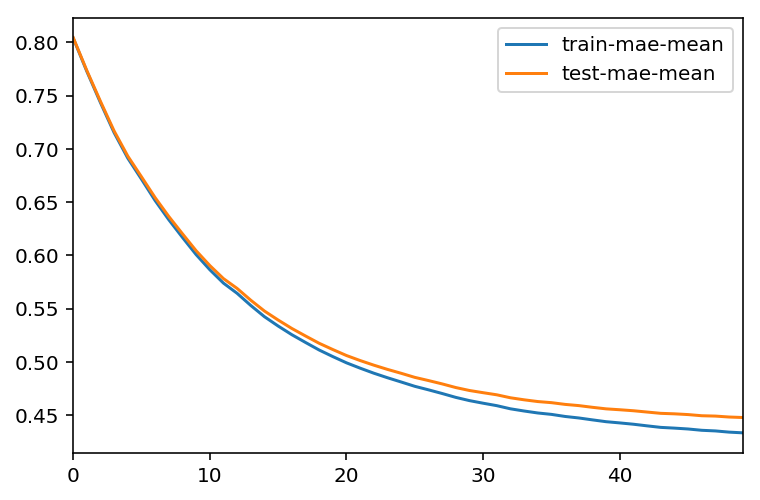

In [7]:
plt.figure()
bst_cv1[['train-mae-mean', 'test-mae-mean']].plot()

In [8]:
%%time
#建立100个树模型
bst_cv2 = xgb.cv(xgb_params, dtrain, num_boost_round=100, 
                nfold=3, seed=0, feval=xg_eval_mae, maximize=False, 
                early_stopping_rounds=10)

print ('CV score:', bst_cv2.iloc[-1,:]['test-mae-mean'])

CV score: 0.44069899999999995
Wall time: 2.99 s


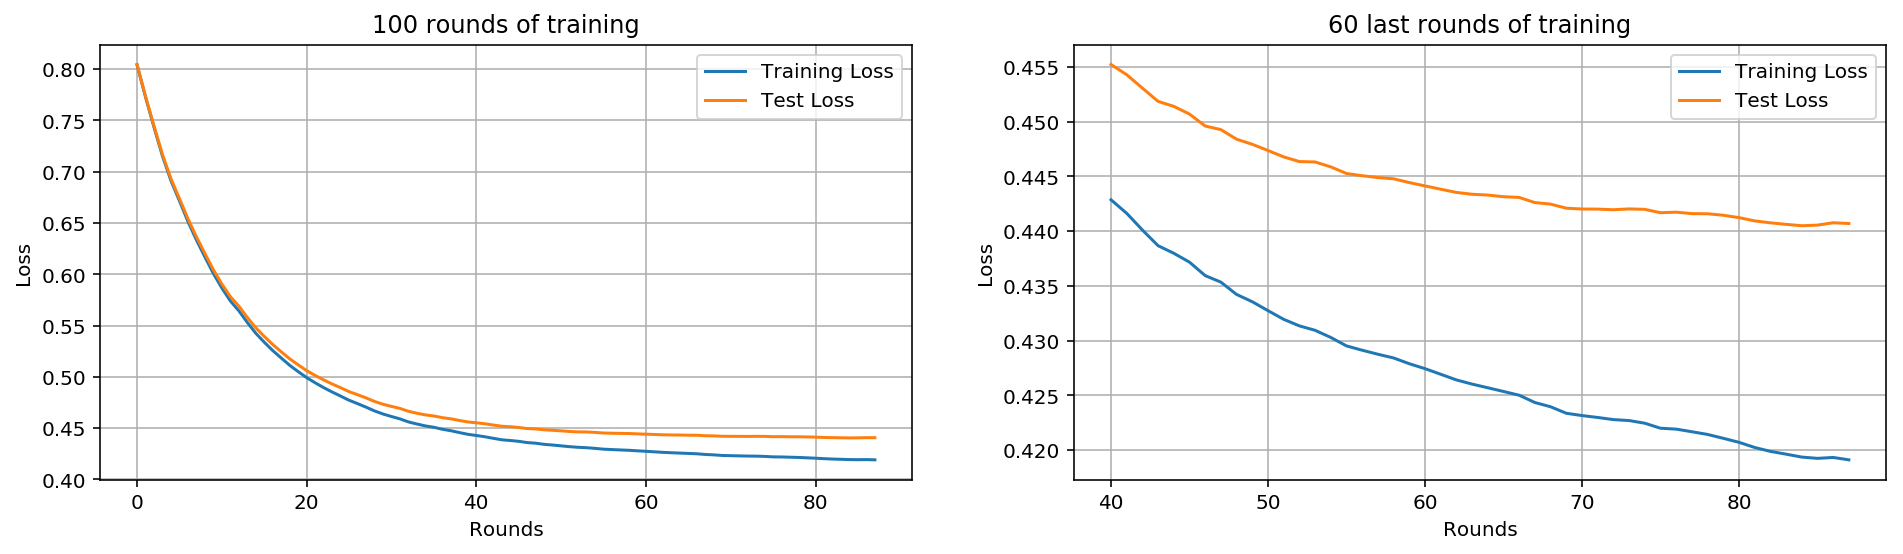

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16,4)

ax1.set_title('100 rounds of training')
ax1.set_xlabel('Rounds')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.plot(bst_cv2[['train-mae-mean', 'test-mae-mean']])
ax1.legend(['Training Loss', 'Test Loss'])

ax2.set_title('60 last rounds of training')
ax2.set_xlabel('Rounds')
ax2.set_ylabel('Loss')
ax2.grid(True)
ax2.plot(bst_cv2.iloc[40:][['train-mae-mean', 'test-mae-mean']])
ax2.legend(['Training Loss', 'Test Loss'])

In [10]:
class XGBoostRegressor(object):
    def __init__(self, **kwargs):
        self.params = kwargs
        if 'num_boost_round' in self.params:
            self.num_boost_round = self.params['num_boost_round']
        self.params.update({'silent': 1, 'objective': 'reg:linear', 'seed': 0})
        
    def fit(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, y_train)
        self.bst = xgb.train(params=self.params, dtrain=dtrain, num_boost_round=self.num_boost_round,
                             feval=xg_eval_mae, maximize=False)
        
    def predict(self, x_pred):
        dpred = xgb.DMatrix(x_pred)
        return self.bst.predict(dpred)
    
    def kfold(self, x_train, y_train, nfold=5):
        dtrain = xgb.DMatrix(x_train, y_train)
        cv_rounds = xgb.cv(params=self.params, dtrain=dtrain, num_boost_round=self.num_boost_round,
                           nfold=nfold, feval=xg_eval_mae, maximize=False, early_stopping_rounds=10)
        return cv_rounds.iloc[-1,:]
    
    def plot_feature_importances(self):
        feat_imp = pd.Series(self.bst.get_fscore()).sort_values(ascending=False)
        feat_imp.plot(title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        
    def get_params(self, deep=True):
        return self.params
 
    def set_params(self, **params):
        self.params.update(params)
        return self

In [11]:
def mae_score(y_true, y_pred):
    return mean_absolute_error(np.exp(y_true), np.exp(y_pred))

mae_scorer = make_scorer(mae_score, greater_is_better=False)

In [12]:
bst = XGBoostRegressor(eta=0.1, colsample_bytree=0.5, subsample=0.5, 
                       max_depth=5, min_child_weight=3, num_boost_round=55)

In [13]:
bst.kfold(train_x, train_y, nfold=5)

test-mae-mean      0.448301
test-mae-std       0.004951
test-rmse-mean     0.357044
test-rmse-std      0.002211
train-mae-mean     0.434173
train-mae-std      0.001460
train-rmse-mean    0.346356
train-rmse-std     0.000576
Name: 54, dtype: float64

In [14]:
xgb_param_grid = {'max_depth': list(range(4,9)), 'min_child_weight': list((1,3,6))}
xgb_param_grid['max_depth']

[4, 5, 6, 7, 8]

In [15]:
%%time
 
grid = GridSearchCV(XGBoostRegressor(eta=0.1, num_boost_round=55, colsample_bytree=0.5, subsample=0.5),
                param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

Wall time: 58.6 s


In [16]:
grid.grid_scores_, grid.best_params_, grid.best_score_

([mean: -0.45217, std: 0.00572, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: -0.45200, std: 0.00607, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: -0.45231, std: 0.00556, params: {'max_depth': 4, 'min_child_weight': 6},
  mean: -0.44764, std: 0.00549, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -0.44733, std: 0.00583, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -0.44735, std: 0.00538, params: {'max_depth': 5, 'min_child_weight': 6},
  mean: -0.44535, std: 0.00588, params: {'max_depth': 6, 'min_child_weight': 1},
  mean: -0.44475, std: 0.00559, params: {'max_depth': 6, 'min_child_weight': 3},
  mean: -0.44453, std: 0.00551, params: {'max_depth': 6, 'min_child_weight': 6},
  mean: -0.44402, std: 0.00600, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: -0.44389, std: 0.00611, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: -0.44432, std: 0.00595, params: {'max_depth': 7, 'min_child_weight': 6},
  mean: -0.44369, std: 0.006

In [17]:
def convert_grid_scores(scores):
    _params = []
    _params_mae = []    
    for i in scores:
        _params.append(i[0].values())
        _params_mae.append(i[1])
    params = np.array(_params)
    grid_res = np.column_stack((_params,_params_mae))
    return [grid_res[:,i] for i in range(grid_res.shape[1])]

In [18]:
_,scores =  convert_grid_scores(grid.grid_scores_)
scores = scores.reshape(5,3)

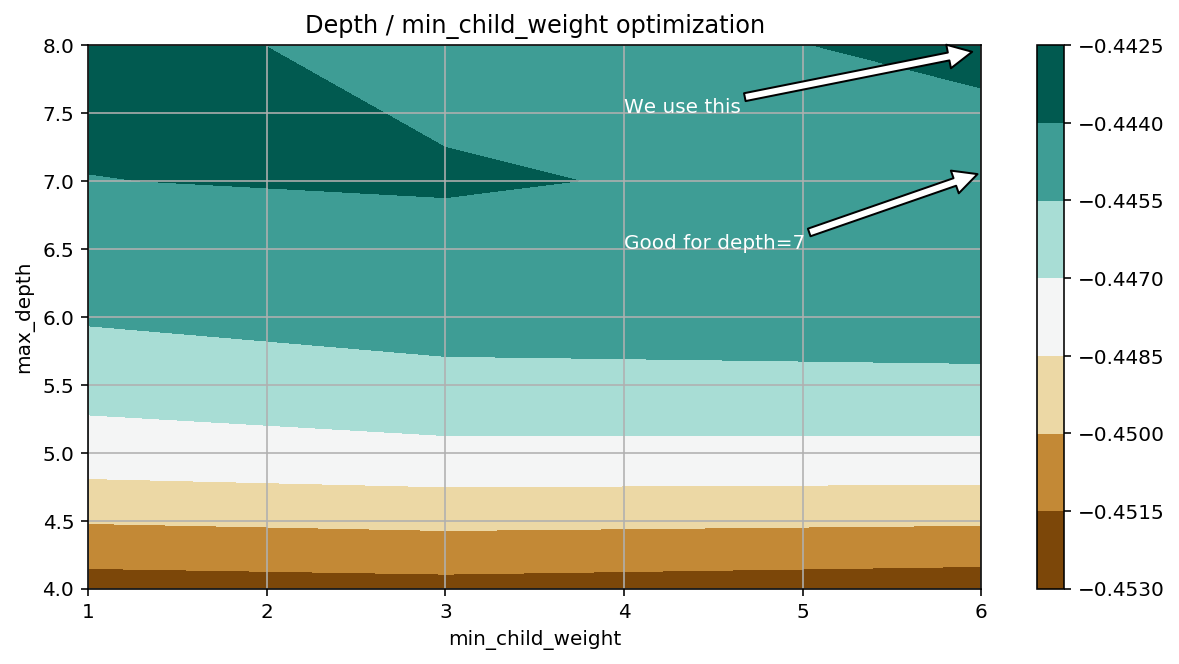

In [19]:
plt.figure(figsize=(10,5))
cp = plt.contourf(xgb_param_grid['min_child_weight'], xgb_param_grid['max_depth'], scores, cmap='BrBG')
plt.colorbar(cp)
plt.title('Depth / min_child_weight optimization')
plt.annotate('We use this', xy=(5.95, 7.95), xytext=(4, 7.5), arrowprops=dict(facecolor='white'), color='white')
plt.annotate('Good for depth=7', xy=(5.98, 7.05), 
             xytext=(4, 6.5), arrowprops=dict(facecolor='white'), color='white')
plt.xlabel('min_child_weight')
plt.ylabel('max_depth')
plt.grid(True)
plt.show()

In [20]:
%%time

xgb_param_grid = {'gamma':[ 0.1 * i for i in range(0,5)]}

grid = GridSearchCV(XGBoostRegressor(eta=0.1, num_boost_round=55, max_depth=7, min_child_weight=6,
                                        colsample_bytree=0.5, subsample=0.5),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

Wall time: 27.4 s


In [21]:
grid.grid_scores_, grid.best_params_, grid.best_score_

([mean: -0.44432, std: 0.00595, params: {'gamma': 0.0},
  mean: -0.44409, std: 0.00603, params: {'gamma': 0.1},
  mean: -0.44395, std: 0.00627, params: {'gamma': 0.2},
  mean: -0.44424, std: 0.00564, params: {'gamma': 0.30000000000000004},
  mean: -0.44396, std: 0.00582, params: {'gamma': 0.4}],
 {'gamma': 0.2},
 -0.4439464422087036)

In [22]:
%%time

xgb_param_grid = {'subsample':[ 0.1 * i for i in range(6,9)],
                      'colsample_bytree':[ 0.1 * i for i in range(6,9)]}


grid = GridSearchCV(XGBoostRegressor(eta=0.1, gamma=0.2, num_boost_round=55, max_depth=7, min_child_weight=6),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)
grid.fit(train_x, train_y.values)

Wall time: 46.8 s


In [23]:
grid.grid_scores_, grid.best_params_, grid.best_score_

([mean: -0.44134, std: 0.00577, params: {'colsample_bytree': 0.6000000000000001, 'subsample': 0.6000000000000001},
  mean: -0.44064, std: 0.00555, params: {'colsample_bytree': 0.6000000000000001, 'subsample': 0.7000000000000001},
  mean: -0.44066, std: 0.00543, params: {'colsample_bytree': 0.6000000000000001, 'subsample': 0.8},
  mean: -0.43802, std: 0.00637, params: {'colsample_bytree': 0.7000000000000001, 'subsample': 0.6000000000000001},
  mean: -0.43847, std: 0.00562, params: {'colsample_bytree': 0.7000000000000001, 'subsample': 0.7000000000000001},
  mean: -0.43803, std: 0.00593, params: {'colsample_bytree': 0.7000000000000001, 'subsample': 0.8},
  mean: -0.43757, std: 0.00583, params: {'colsample_bytree': 0.8, 'subsample': 0.6000000000000001},
  mean: -0.43728, std: 0.00557, params: {'colsample_bytree': 0.8, 'subsample': 0.7000000000000001},
  mean: -0.43672, std: 0.00589, params: {'colsample_bytree': 0.8, 'subsample': 0.8}],
 {'colsample_bytree': 0.8, 'subsample': 0.8},
 -0.4367

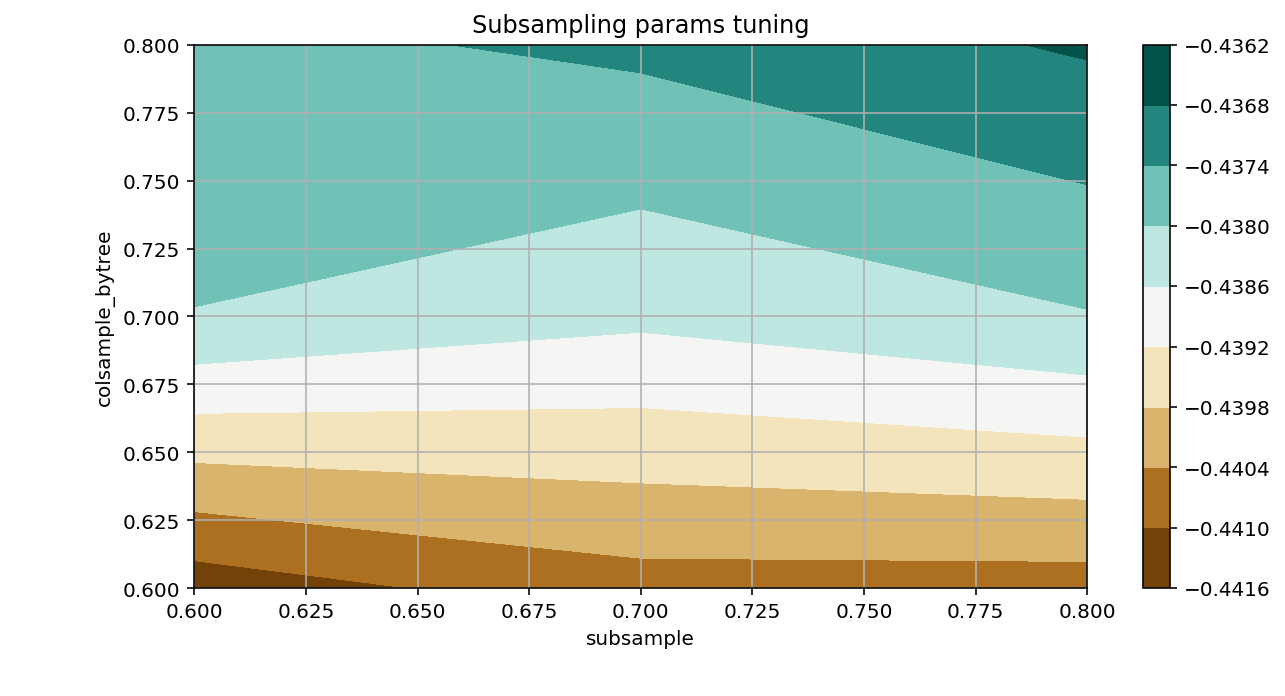

In [24]:
_, scores =  convert_grid_scores(grid.grid_scores_)
scores = scores.reshape(3,3)

plt.figure(figsize=(10,5))
cp = plt.contourf(xgb_param_grid['subsample'], xgb_param_grid['colsample_bytree'], scores, cmap='BrBG')
plt.colorbar(cp)
plt.title('Subsampling params tuning')
plt.annotate('Optimum', xy=(0.895, 0.6), xytext=(0.8, 0.695), arrowprops=dict(facecolor='black'))
plt.xlabel('subsample')
plt.ylabel('colsample_bytree')
plt.grid(True)
plt.show()

In [25]:
%%time
    
xgb_param_grid = {'eta':[0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=55, gamma=0.2, max_depth=7, min_child_weight=6,
                                        colsample_bytree=0.6, subsample=0.9),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

Wall time: 37.6 s


In [26]:
grid.grid_scores_, grid.best_params_, grid.best_score_

([mean: -0.45989, std: 0.00378, params: {'eta': 0.5},
  mean: -0.45202, std: 0.00468, params: {'eta': 0.4},
  mean: -0.44511, std: 0.00547, params: {'eta': 0.3},
  mean: -0.44020, std: 0.00482, params: {'eta': 0.2},
  mean: -0.44052, std: 0.00564, params: {'eta': 0.1},
  mean: -0.44727, std: 0.00480, params: {'eta': 0.075},
  mean: -0.47233, std: 0.00514, params: {'eta': 0.05},
  mean: -0.49408, std: 0.00516, params: {'eta': 0.04},
  mean: -0.52971, std: 0.00505, params: {'eta': 0.03}],
 {'eta': 0.2},
 -0.4401973179272151)

In [27]:
#eta , y = convert_grid_scores(grid.grid_scores_)

# plt.figure(figsize=(10,4))
# plt.title('MAE and ETA, 55 trees')
# plt.xlabel('eta')
# plt.ylabel('score')
# plt.plot(eta, -y)
# plt.grid(True)
# plt.show()

In [28]:

xgb_param_grid = {'eta':[0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=110, gamma=0.2, max_depth=7, min_child_weight=6,
                                        colsample_bytree=0.6, subsample=0.9),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

GridSearchCV(cv=5, error_score='raise',
       estimator=<__main__.XGBoostRegressor object at 0x0000028200DF81D0>,
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'eta': [0.5, 0.4, 0.3, 0.2, 0.1, 0.075, 0.05, 0.04, 0.03]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(mae_score, greater_is_better=False), verbose=0)

In [29]:
grid.grid_scores_, grid.best_params_, grid.best_score_

([mean: -0.47264, std: 0.00286, params: {'eta': 0.5},
  mean: -0.46170, std: 0.00588, params: {'eta': 0.4},
  mean: -0.45028, std: 0.00599, params: {'eta': 0.3},
  mean: -0.44183, std: 0.00476, params: {'eta': 0.2},
  mean: -0.43674, std: 0.00622, params: {'eta': 0.1},
  mean: -0.43690, std: 0.00557, params: {'eta': 0.075},
  mean: -0.43974, std: 0.00584, params: {'eta': 0.05},
  mean: -0.44511, std: 0.00602, params: {'eta': 0.04},
  mean: -0.45864, std: 0.00609, params: {'eta': 0.03}],
 {'eta': 0.1},
 -0.43674318757190156)

In [30]:
%%time

xgb_param_grid = {'eta':[0.09,0.08,0.07,0.06,0.05,0.04]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=220, gamma=0.2, max_depth=7, min_child_weight=6,
                                        colsample_bytree=0.6, subsample=0.9),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

Wall time: 1min 49s


In [31]:
grid.grid_scores_, grid.best_params_, grid.best_score_

([mean: -0.43750, std: 0.00568, params: {'eta': 0.09},
  mean: -0.43688, std: 0.00562, params: {'eta': 0.08},
  mean: -0.43600, std: 0.00575, params: {'eta': 0.07},
  mean: -0.43511, std: 0.00533, params: {'eta': 0.06},
  mean: -0.43567, std: 0.00560, params: {'eta': 0.05},
  mean: -0.43581, std: 0.00589, params: {'eta': 0.04}],
 {'eta': 0.06},
 -0.4351138393712138)

In [32]:
# eta, y = convert_grid_scores(grid.grid_scores_)
# plt.figure(figsize=(10,4))
# plt.title('MAE and ETA, 200 trees')
# plt.xlabel('eta')
# plt.ylabel('score')
# plt.plot(eta, -y)
# plt.grid(True)
# plt.show()

In [33]:
%%time

# Final XGBoost model


bst = XGBoostRegressor(num_boost_round=220, eta=0.05, gamma=0.2, max_depth=7, min_child_weight=6,
                                        colsample_bytree=0.6, subsample=0.9)
cv = bst.kfold(train_x, train_y, nfold=5)

Wall time: 12.4 s


In [34]:
pd_3
features = ['register_day','register_type','device type','user_activity_day','video_create_day','p_0','p_1','p_2','p_3','p_4','a_0','a_1','a_2','a_3','a_4','a_5']

test_x = pd_3[features]


In [35]:
from sklearn.cross_validation import train_test_split

x,val_x = train_test_split(train_x, test_size = 0.3,random_state=1)
y,val_y = train_test_split(train_y, test_size = 0.3,random_state=1)



In [36]:
from sklearn.model_selection import StratifiedKFold
params = {

'booster': 'gbtree',

 'objective': 'multi:softmax', # 多分类的问题、

#'objective': 'multi:softprob', # 多分类概率

'objective': 'binary:logistic',

'eval_metric': 'logloss',

#'num_class': 2, # 类别数，与 multisoftmax 并用

'gamma': 0.2, # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。

'max_depth': 7, # 构建树的深度，越大越容易过拟合

'alpha': 0, # L1正则化系数

'lambda': 8, # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。

'subsample': 0.9, # 随机采样训练样本

'colsample_bytree': 0.6, # 生成树时进行的列采样

'min_child_weight': 6,

# 这个参数默认是 1，是每个叶子里面 h 的和至少是多少，对正负样本不均衡时的 0-1 分类而言

# ，假设 h 在 0.01 附近，min_child_weight 为 1 意味着叶子节点中最少需要包含 100 个样本。

# 这个参数非常影响结果，控制叶子节点中二阶导的和的最小值，该参数值越小，越容易 overfitting。

'silent': 0, # 设置成1则没有运行信息输出，最好是设置为0.

'eta': 0.01, # 如同学习率

'seed': 1000,

'nthread': -1, # cpu 线程数

'missing': 1,

#'scale_pos_weight': (np.sum(y==0)/np.sum(y==1)) # 用来处理正负样本不均衡的问题,通常取：sum(negative cases) / sum(positive cases)

# 'eval_metric': 'auc'

}

plst = list(params.items())

num_rounds = 2000 # 迭代次数
xgb_val = xgb.DMatrix(val_x,label=val_y)
xgb_train = xgb.DMatrix(x, label=y)
xgb_test = xgb.DMatrix(test_x)

watchlist = [(xgb_train, 'train'), (xgb_val, 'val')]

# 交叉验证

result = xgb.cv(plst, xgb_train, num_boost_round=220, nfold=5, early_stopping_rounds=200, verbose_eval=True, folds=StratifiedKFold(n_splits=5).split(x, y))

# 训练模型并保存

# early_stopping_rounds 当设置的迭代次数较大时，early_stopping_rounds 可在一定的迭代次数内准确率没有提升就停止训练

model = xgb.train(plst, xgb_train, num_rounds, watchlist, early_stopping_rounds=200)

model.save_model('./xgb.model') # 用于存储训练出的模型

preds = model.predict(xgb_test)

[0]	train-logloss:0.688759+8.6368e-05	test-logloss:0.68885+0.000100487
[1]	train-logloss:0.684221+8.89553e-05	test-logloss:0.684417+0.000109308
[2]	train-logloss:0.679924+0.000174587	test-logloss:0.680214+0.000234443
[3]	train-logloss:0.675787+0.000310354	test-logloss:0.676218+0.000346785
[4]	train-logloss:0.671663+0.000264055	test-logloss:0.672205+0.000293907
[5]	train-logloss:0.667692+0.000543956	test-logloss:0.668367+0.000471727
[6]	train-logloss:0.663741+0.000472746	test-logloss:0.664523+0.000432516
[7]	train-logloss:0.660009+0.000509436	test-logloss:0.660881+0.000485979
[8]	train-logloss:0.656048+0.000463463	test-logloss:0.657047+0.000400883
[9]	train-logloss:0.652092+0.000491022	test-logloss:0.653197+0.000446236
[10]	train-logloss:0.648308+0.000546962	test-logloss:0.649506+0.000453269
[11]	train-logloss:0.644651+0.000541053	test-logloss:0.64593+0.000607194
[12]	train-logloss:0.641021+0.000441013	test-logloss:0.642388+0.000616214
[13]	train-logloss:0.63745+0.000441601	test-logloss

[113]	train-logloss:0.453551+0.000395265	test-logloss:0.464813+0.0029722
[114]	train-logloss:0.452636+0.000452522	test-logloss:0.463995+0.00297055
[115]	train-logloss:0.451758+0.000450119	test-logloss:0.463219+0.00297734
[116]	train-logloss:0.450943+0.000472676	test-logloss:0.462487+0.00298451
[117]	train-logloss:0.450098+0.000456564	test-logloss:0.461725+0.00296433
[118]	train-logloss:0.449233+0.00051062	test-logloss:0.460947+0.00296083
[119]	train-logloss:0.448429+0.000548508	test-logloss:0.460229+0.00295365
[120]	train-logloss:0.447594+0.000602866	test-logloss:0.459479+0.00296299
[121]	train-logloss:0.446782+0.000626869	test-logloss:0.458762+0.00294535
[122]	train-logloss:0.445975+0.000614819	test-logloss:0.458048+0.00298253
[123]	train-logloss:0.445234+0.000624037	test-logloss:0.45738+0.00293769
[124]	train-logloss:0.444429+0.000664509	test-logloss:0.456672+0.00294881
[125]	train-logloss:0.443684+0.000684152	test-logloss:0.455987+0.00301006
[126]	train-logloss:0.442893+0.000694667	

[4]	train-logloss:0.672405	val-logloss:0.672899
[5]	train-logloss:0.668474	val-logloss:0.669078
[6]	train-logloss:0.664398	val-logloss:0.665136
[7]	train-logloss:0.660316	val-logloss:0.661204
[8]	train-logloss:0.656558	val-logloss:0.657569
[9]	train-logloss:0.652924	val-logloss:0.654014
[10]	train-logloss:0.649462	val-logloss:0.650708
[11]	train-logloss:0.645749	val-logloss:0.647113
[12]	train-logloss:0.641994	val-logloss:0.64348
[13]	train-logloss:0.638218	val-logloss:0.639834
[14]	train-logloss:0.634782	val-logloss:0.63649
[15]	train-logloss:0.631102	val-logloss:0.632961
[16]	train-logloss:0.627675	val-logloss:0.629629
[17]	train-logloss:0.624086	val-logloss:0.626187
[18]	train-logloss:0.620948	val-logloss:0.623163
[19]	train-logloss:0.617486	val-logloss:0.619842
[20]	train-logloss:0.614286	val-logloss:0.616761
[21]	train-logloss:0.611126	val-logloss:0.613717
[22]	train-logloss:0.608187	val-logloss:0.610852
[23]	train-logloss:0.605154	val-logloss:0.607932
[24]	train-logloss:0.602207	

[171]	train-logloss:0.415887	val-logloss:0.433087
[172]	train-logloss:0.415447	val-logloss:0.432724
[173]	train-logloss:0.414992	val-logloss:0.432356
[174]	train-logloss:0.414585	val-logloss:0.432027
[175]	train-logloss:0.414106	val-logloss:0.431625
[176]	train-logloss:0.413688	val-logloss:0.431282
[177]	train-logloss:0.413344	val-logloss:0.431013
[178]	train-logloss:0.412931	val-logloss:0.430673
[179]	train-logloss:0.412563	val-logloss:0.430347
[180]	train-logloss:0.412074	val-logloss:0.429964
[181]	train-logloss:0.41159	val-logloss:0.429568
[182]	train-logloss:0.411118	val-logloss:0.429178
[183]	train-logloss:0.410624	val-logloss:0.428783
[184]	train-logloss:0.410161	val-logloss:0.428432
[185]	train-logloss:0.409685	val-logloss:0.42805
[186]	train-logloss:0.409304	val-logloss:0.427743
[187]	train-logloss:0.408865	val-logloss:0.427399
[188]	train-logloss:0.408455	val-logloss:0.427093
[189]	train-logloss:0.408025	val-logloss:0.426754
[190]	train-logloss:0.407671	val-logloss:0.426459
[1

[336]	train-logloss:0.376059	val-logloss:0.404929
[337]	train-logloss:0.375919	val-logloss:0.404864
[338]	train-logloss:0.375805	val-logloss:0.404812
[339]	train-logloss:0.375697	val-logloss:0.404766
[340]	train-logloss:0.375539	val-logloss:0.404715
[341]	train-logloss:0.375409	val-logloss:0.404638
[342]	train-logloss:0.375289	val-logloss:0.404605
[343]	train-logloss:0.375171	val-logloss:0.404545
[344]	train-logloss:0.375087	val-logloss:0.404519
[345]	train-logloss:0.37495	val-logloss:0.404461
[346]	train-logloss:0.374849	val-logloss:0.404423
[347]	train-logloss:0.374755	val-logloss:0.404392
[348]	train-logloss:0.374619	val-logloss:0.404317
[349]	train-logloss:0.374525	val-logloss:0.404264
[350]	train-logloss:0.374458	val-logloss:0.40424
[351]	train-logloss:0.374319	val-logloss:0.404177
[352]	train-logloss:0.374166	val-logloss:0.404105
[353]	train-logloss:0.374036	val-logloss:0.404057
[354]	train-logloss:0.373924	val-logloss:0.404005
[355]	train-logloss:0.373835	val-logloss:0.403955
[3

[501]	train-logloss:0.361797	val-logloss:0.399836
[502]	train-logloss:0.361744	val-logloss:0.399824
[503]	train-logloss:0.361683	val-logloss:0.399804
[504]	train-logloss:0.361619	val-logloss:0.3998
[505]	train-logloss:0.36156	val-logloss:0.399779
[506]	train-logloss:0.361497	val-logloss:0.399772
[507]	train-logloss:0.361459	val-logloss:0.399762
[508]	train-logloss:0.361409	val-logloss:0.399752
[509]	train-logloss:0.361371	val-logloss:0.399753
[510]	train-logloss:0.36132	val-logloss:0.399725
[511]	train-logloss:0.361286	val-logloss:0.39972
[512]	train-logloss:0.361216	val-logloss:0.399705
[513]	train-logloss:0.361179	val-logloss:0.399709
[514]	train-logloss:0.36112	val-logloss:0.399701
[515]	train-logloss:0.36105	val-logloss:0.399694
[516]	train-logloss:0.360998	val-logloss:0.399677
[517]	train-logloss:0.360938	val-logloss:0.399663
[518]	train-logloss:0.360872	val-logloss:0.399659
[519]	train-logloss:0.360804	val-logloss:0.399646
[520]	train-logloss:0.360728	val-logloss:0.399625
[521]	t

[666]	train-logloss:0.354045	val-logloss:0.39871
[667]	train-logloss:0.354004	val-logloss:0.398695
[668]	train-logloss:0.353965	val-logloss:0.398698
[669]	train-logloss:0.35393	val-logloss:0.398692
[670]	train-logloss:0.353882	val-logloss:0.398696
[671]	train-logloss:0.353831	val-logloss:0.398677
[672]	train-logloss:0.353804	val-logloss:0.398675
[673]	train-logloss:0.353755	val-logloss:0.398665
[674]	train-logloss:0.353724	val-logloss:0.398667
[675]	train-logloss:0.35368	val-logloss:0.39866
[676]	train-logloss:0.353637	val-logloss:0.398656
[677]	train-logloss:0.353593	val-logloss:0.398657
[678]	train-logloss:0.35357	val-logloss:0.398662
[679]	train-logloss:0.353517	val-logloss:0.398666
[680]	train-logloss:0.353505	val-logloss:0.398666
[681]	train-logloss:0.353444	val-logloss:0.398655
[682]	train-logloss:0.353413	val-logloss:0.398659
[683]	train-logloss:0.353361	val-logloss:0.398656
[684]	train-logloss:0.353326	val-logloss:0.39865
[685]	train-logloss:0.353284	val-logloss:0.398643
[686]	

[831]	train-logloss:0.348511	val-logloss:0.398458
[832]	train-logloss:0.348473	val-logloss:0.398456
[833]	train-logloss:0.348466	val-logloss:0.398462
[834]	train-logloss:0.348426	val-logloss:0.398455
[835]	train-logloss:0.348407	val-logloss:0.398454
[836]	train-logloss:0.348379	val-logloss:0.398459
[837]	train-logloss:0.348356	val-logloss:0.398449
[838]	train-logloss:0.348317	val-logloss:0.398459
[839]	train-logloss:0.348272	val-logloss:0.398448
[840]	train-logloss:0.348224	val-logloss:0.398456
[841]	train-logloss:0.348195	val-logloss:0.398453
[842]	train-logloss:0.348178	val-logloss:0.398453
[843]	train-logloss:0.348152	val-logloss:0.398452
[844]	train-logloss:0.348118	val-logloss:0.398449
[845]	train-logloss:0.348084	val-logloss:0.398449
[846]	train-logloss:0.348065	val-logloss:0.398448
[847]	train-logloss:0.348016	val-logloss:0.398448
[848]	train-logloss:0.347989	val-logloss:0.398447
[849]	train-logloss:0.347979	val-logloss:0.398449
[850]	train-logloss:0.34794	val-logloss:0.398444
[

[996]	train-logloss:0.343758	val-logloss:0.398559
[997]	train-logloss:0.343741	val-logloss:0.398564
[998]	train-logloss:0.343703	val-logloss:0.398563
[999]	train-logloss:0.343689	val-logloss:0.398566
[1000]	train-logloss:0.343672	val-logloss:0.398563
[1001]	train-logloss:0.343652	val-logloss:0.398558
[1002]	train-logloss:0.343638	val-logloss:0.398558
[1003]	train-logloss:0.343632	val-logloss:0.398558
[1004]	train-logloss:0.3436	val-logloss:0.398555
[1005]	train-logloss:0.343569	val-logloss:0.398557
[1006]	train-logloss:0.343533	val-logloss:0.398564
[1007]	train-logloss:0.343507	val-logloss:0.398563
[1008]	train-logloss:0.343478	val-logloss:0.39856
[1009]	train-logloss:0.343453	val-logloss:0.398564
[1010]	train-logloss:0.343444	val-logloss:0.398567
[1011]	train-logloss:0.343402	val-logloss:0.39857
[1012]	train-logloss:0.343384	val-logloss:0.398568
[1013]	train-logloss:0.343345	val-logloss:0.398568
[1014]	train-logloss:0.343334	val-logloss:0.398571
[1015]	train-logloss:0.343287	val-loglo

In [37]:
preds

array([0.4479972 , 0.24719995, 0.37889034, ..., 0.2100083 , 0.29565945,
       0.8733852 ], dtype=float32)

In [38]:
threshold = 0.30
results = []
for pred in preds:
    if pred > threshold:
        result = 1 
    else:
        result = 0
    results.append(result)
results    

[1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [39]:
pre_l = pd.Series(results)
pre_l.value_counts()

0    30606
1    21103
dtype: int64

In [40]:
df = pd.read_csv('./data/all.csv')
df['label'] = pre_l

In [41]:
df

,user_id,register_day,register_type,device type,a_p_day,user_activity_day,video_create_day,p_0,p_1,p_2,p_3,p_4,a_0,a_1,a_2,a_3,a_4,a_5,label
0,744025,1,1,283,3,111.0,0.0,99.0,0.0,10.0,2.0,0.0,109.0,2.0,0.0,0.0,0.0,0.0,1
1,1270299,1,1,259,2,85.0,0.0,13.0,54.0,0.0,18.0,0.0,81.0,0.0,0.0,4.0,0.0,0.0,0
2,571220,1,1,2,10,424.0,0.0,209.0,5.0,45.0,165.0,0.0,418.0,4.0,2.0,0.0,0.0,0.0,1
3,1308501,1,0,23,15,173.0,0.0,16.0,83.0,3.0,71.0,0.0,154.0,18.0,0.0,1.0,0.0,0.0,0
4,745554,1,2,0,11,35.0,0.0,8.0,5.0,22.0,0.0,0.0,33.0,1.0,1.0,0.0,0.0,0.0,0
5,1031012,1,1,650,6,1983.0,2.0,612.0,267.0,6.0,1098.0,0.0,1904.0,60.0,18.0,1.0,0.0,0.0,1
6,913297,1,2,593,15,257.0,0.0,99.0,12.0,133.0,13.0,0.0,257.0,0.0,0.0,0.0,0.0,0.0,1
7,266500,1,0,403,6,221.0,0.0,11.0,26.0,14.0,170.0,0.0,212.0,3.0,3.0,3.0,0.0,0.0,1
8,475120,1,0,135,2,5.0,1.0,0.0,0.0,4.0,1.0,0.0,3.0,0.0,2.0,0.0,0.0,0.0,1
9,547944,1,0,9,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [42]:
df_1 = df[df['label']==1]
lei = df_1['user_id']
lei.to_csv('go_go_go.csv',index=None)